In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import random
from torch.utils.data import DataLoader, random_split, Subset
from torchvision.models import resnet18
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit , StratifiedKFold
import numpy as np
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the random seed for reproducibility
set_seed(42)

In [3]:
#defining class names for use
classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Generating input data for contrastive learning

 color distortion composed by color jittering and color dropping.
 See Section A of SimCLR: https://arxiv.org/abs/2002.05709

In [4]:
def color_distortion(s=0.5):  # 0.5 for CIFAR10 by default
    # s is the strength of color distortion
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
    rnd_gray = transforms.RandomGrayscale(p=0.2)
    color_distort = transforms.Compose([rnd_color_jitter, rnd_gray])
    return color_distort

Data augmentation 1: Inception crop and resize to 32x32(with random flip)

Data augmentation 2: color distortion (strength=0.5)

leaving out Gaussian blur for CIFAR-10

In [5]:
transform_CLtrain = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(p=0.5),
    color_distortion(s=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_CLtest = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [6]:
class CIFAR10Pair(CIFAR10):  #CIFAR10Pair inherits from the CIFAR10 dataset class,i.e child class
    def __getitem__(self, index): # The __getitem__ method is overridden to get a positive pair of imgs and a label
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        
        if self.transform is not None: #Checks if any data transformations are specified.
            x_i = self.transform(img)  # Applies the transformation twice
            x_j = self.transform(img)  # due to the randomness in the transformations, x_i and x_j will be different augmented versions of the same image.
        if self.target_transform is not None:  #Checks if any target transformations are specified.
            target = self.target_transform(target) #Applies the target transformation to the target, if any.


        return x_i, x_j, target

In [7]:
ConLearn_train_data = CIFAR10Pair(root='./CLdata', train=True, transform=transform_CLtrain, download=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.378921..2.7537313].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1770618..1.4855624].


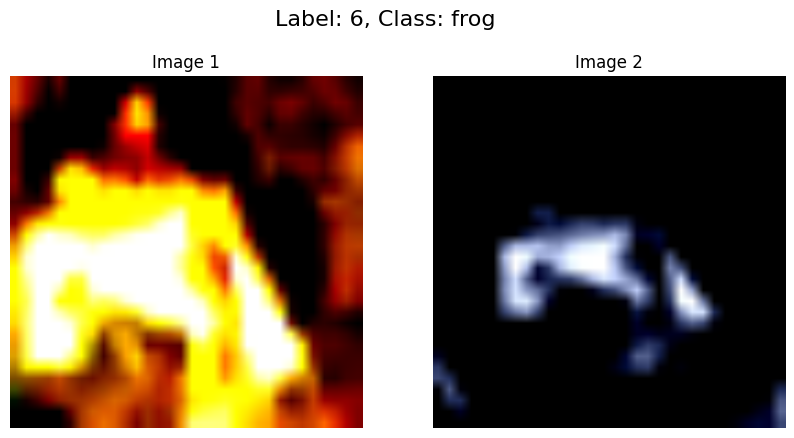

In [8]:
img1,img2,label = ConLearn_train_data[0]

# Convert the tensors to NumPy arrays
img1 = img1.permute(1, 2, 0).numpy()  # Change the dimensions to (height, width, channels)
img2 = img2.permute(1, 2, 0).numpy()

# Plotting the images using matplotlib with bilinear interpolation
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img1, interpolation='bilinear')
ax[0].set_title('Image 1')
ax[0].axis('off')

ax[1].imshow(img2, interpolation='bilinear')
ax[1].set_title('Image 2')
ax[1].axis('off')

# Add a title to the entire figure
plt.suptitle(f'Label: {label}, Class: {classes[label]}', fontsize=16)

plt.show()

# Contrastive Learning - Pre Training

In [9]:
batch_size = 256
#learningrate =  1e-3
temperature = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
ConLearn_traindata_loader = DataLoader(ConLearn_train_data, batch_size=batch_size, shuffle=True, num_workers = 4, pin_memory=True, drop_last=True)
num_batches = len(ConLearn_traindata_loader)
print(num_batches)

195


/home/noranm/miniconda3/envs/cs236781-hw/lib/python3.9/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Defining the pre training contrastive learning model

In [11]:
class PreTrainModel(nn.Module):
    def __init__(self, projection_dim=128):
        super().__init__()
        
        # Initialize ResNet-18 without pretrained weights
        self.enc = resnet18(pretrained=False)
        self.feature_dim = self.enc.fc.in_features # feature dim = output of gap layer dim or input of FC layer dim
        
        # Customize for CIFAR10. Replace conv 7x7 with conv 3x3, and remove first max pooling.
        # See Section B.9 of SimCLR paper.
        self.enc.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.enc.maxpool = nn.Identity()
        self.enc.fc = nn.Identity()  # remove final fully connected layer.
        
        # Add MLP projection.
        self.projection_dim = projection_dim
        # since we are using resnet-18 we use middle layer dim as 512, for resnet-50 it's 2048 in paper.
        self.projector = nn.Sequential(nn.Linear(self.feature_dim, 512, bias=False),#nn.BatchNorm1d(512),
                                       nn.ReLU(inplace=True), 
                                       nn.Linear(512, projection_dim, bias=True))
     

    def forward(self, x):
        feature = self.enc(x)
        projection = self.projector(feature)
        return feature, projection

Define Contrastive Loss

In [12]:
def ContrastiveLoss(p_i, p_j):
    N = p_i.shape[0]
    Z = torch.cat([p_i, p_j], dim=0) # concat p_i and p_j one below the other
    Z_hat = Z/torch.linalg.norm(Z,dim=1,keepdim=True) # Normalize all the Zi's
    sim_mat = Z_hat@Z_hat.transpose(0,1) # .transpose(0,1) is a way of transposing torch tensors, as Z_hat is a tensor, similar to np.transpose for numpy array
    exp_simmat = (sim_mat/temperature).exp() # compute exponent of similarities
    exp_simmat = exp_simmat.to(device) # move exponential similarity matrix to GPU
    
    # Create a mask to zero out the diagonal without using in-place operations like fill_diagonal_ which are non-differentiable
    mask = torch.eye(exp_simmat.shape[0], device=device).bool()
    exp_simmat = exp_simmat.masked_fill(mask, 0)  # Zero out the diagonal
    
    # calculating denominator
    denominator = exp_simmat.sum(dim=1) # Sum along dim=1 (rows)
    
    # calculating numerator
    numerator = torch.zeros_like(denominator)
    for i in range(N):
        j = N+i
        numerator[i] = exp_simmat[i, j]
        numerator[j] = exp_simmat[j, i]
        
    # Compute contrastive loss
    loss = torch.log(denominator / numerator).sum() / (2 * N) # torch.log is ln
    
    return loss

In [13]:
CL_Model = PreTrainModel()
CL_Model.to(device)

/home/noranm/miniconda3/envs/cs236781-hw/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/noranm/miniconda3/envs/cs236781-hw/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


PreTrainModel(
  (enc): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (c

Doing Contrastive Learning

In [14]:
# In paper: optimized using LARS with learning rate of 4.8 (= 0.3 × BatchSize(4096)/256) and weight decay of 10−6.
optimizer = optim.Adam(CL_Model.parameters(), lr=0.001 , weight_decay=1e-6)

# ExponentialLR scheduler for learning rate decay
#exp_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
step_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.6)

In [15]:
num_epochs = 50
for epoch in range(num_epochs):
    for param_group in optimizer.param_groups:
        print(f'Start of Epoch {epoch+1}/{num_epochs}, Learning Rate: {param_group["lr"]:.6f}')
    CL_Model.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running loss, it is used to accumulate the total loss of all elements in a epoch
    for batch_id, (x_i, x_j, _) in enumerate(ConLearn_traindata_loader): # adds a counter-batch_id and loads pair of images into x_i and x_j ignoring the targets
        x_i, x_j = x_i.to(device), x_j.to(device)
            
        # Forward pass
        _ , p_i = CL_Model(x_i)
        _ , p_j = CL_Model(x_j)
        loss = ContrastiveLoss(p_i, p_j) #Calculate the loss
        running_loss += loss.item()  # Accumulate loss from each iteration/batch.
        #if (batch_id+1) % 50 == 0:
        #    print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_id+1}/{num_batches}], Loss: {loss.item():.4f}')
            
        # Backward pass and optimization
        optimizer.zero_grad()   # Step 1: Clear old gradients
        loss.backward()         # Step 2: Compute new gradients, i.e Backward pass: Compute gradient of the loss with respect to model parameters
        optimizer.step()        # Step 3: Update model parameters
                         
    epoch_loss = running_loss / num_batches
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    
    step_scheduler.step() # Update learning rate using step scheduler
            

Start of Epoch 1/50, Learning Rate: 0.001000


Epoch 1/50, Loss: 5.5161
Start of Epoch 2/50, Learning Rate: 0.001000


Epoch 2/50, Loss: 5.2450
Start of Epoch 3/50, Learning Rate: 0.001000


Epoch 3/50, Loss: 5.1509
Start of Epoch 4/50, Learning Rate: 0.001000


Epoch 4/50, Loss: 5.0786
Start of Epoch 5/50, Learning Rate: 0.001000


Epoch 5/50, Loss: 5.0289
Start of Epoch 6/50, Learning Rate: 0.001000


Epoch 6/50, Loss: 4.9994
Start of Epoch 7/50, Learning Rate: 0.001000


Epoch 7/50, Loss: 4.9756
Start of Epoch 8/50, Learning Rate: 0.001000


Epoch 8/50, Loss: 4.9590
Start of Epoch 9/50, Learning Rate: 0.001000


Epoch 9/50, Loss: 4.9391
Start of Epoch 10/50, Learning Rate: 0.001000


Epoch 10/50, Loss: 4.9203
Start of Epoch 11/50, Learning Rate: 0.000600


Epoch 11/50, Loss: 4.8886
Start of Epoch 12/50, Learning Rate: 0.000600


Epoch 12/50, Loss: 4.8806
Start of Epoch 13/50, Learning Rate: 0.000600


Epoch 13/50, Loss: 4.8741
Start of Epoch 14/50, Learning Rate: 0.000600


Epoch 14/50, Loss: 4.8637
Start of Epoch 15/50, Learning Rate: 0.000600


Epoch 15/50, Loss: 4.8550
Start of Epoch 16/50, Learning Rate: 0.000600


Epoch 16/50, Loss: 4.8556
Start of Epoch 17/50, Learning Rate: 0.000600


Epoch 17/50, Loss: 4.8481
Start of Epoch 18/50, Learning Rate: 0.000600


Epoch 18/50, Loss: 4.8436
Start of Epoch 19/50, Learning Rate: 0.000600


Epoch 19/50, Loss: 4.8351
Start of Epoch 20/50, Learning Rate: 0.000600


Epoch 20/50, Loss: 4.8343
Start of Epoch 21/50, Learning Rate: 0.000360


Epoch 21/50, Loss: 4.8168
Start of Epoch 22/50, Learning Rate: 0.000360


Epoch 22/50, Loss: 4.8088
Start of Epoch 23/50, Learning Rate: 0.000360


Epoch 23/50, Loss: 4.8056
Start of Epoch 24/50, Learning Rate: 0.000360


Epoch 24/50, Loss: 4.8004
Start of Epoch 25/50, Learning Rate: 0.000360


Epoch 25/50, Loss: 4.8008
Start of Epoch 26/50, Learning Rate: 0.000360


Epoch 26/50, Loss: 4.7999
Start of Epoch 27/50, Learning Rate: 0.000360


Epoch 27/50, Loss: 4.7963
Start of Epoch 28/50, Learning Rate: 0.000360


Epoch 28/50, Loss: 4.7974
Start of Epoch 29/50, Learning Rate: 0.000360


Epoch 29/50, Loss: 4.7934
Start of Epoch 30/50, Learning Rate: 0.000360


Epoch 30/50, Loss: 4.7886
Start of Epoch 31/50, Learning Rate: 0.000216


Epoch 31/50, Loss: 4.7733
Start of Epoch 32/50, Learning Rate: 0.000216


Epoch 32/50, Loss: 4.7731
Start of Epoch 33/50, Learning Rate: 0.000216


Epoch 33/50, Loss: 4.7707
Start of Epoch 34/50, Learning Rate: 0.000216


Epoch 34/50, Loss: 4.7686
Start of Epoch 35/50, Learning Rate: 0.000216


Epoch 35/50, Loss: 4.7664
Start of Epoch 36/50, Learning Rate: 0.000216


Epoch 36/50, Loss: 4.7668
Start of Epoch 37/50, Learning Rate: 0.000216


Epoch 37/50, Loss: 4.7663
Start of Epoch 38/50, Learning Rate: 0.000216


Epoch 38/50, Loss: 4.7660
Start of Epoch 39/50, Learning Rate: 0.000216


Epoch 39/50, Loss: 4.7634
Start of Epoch 40/50, Learning Rate: 0.000216


Epoch 40/50, Loss: 4.7630
Start of Epoch 41/50, Learning Rate: 0.000130


Epoch 41/50, Loss: 4.7547
Start of Epoch 42/50, Learning Rate: 0.000130


Epoch 42/50, Loss: 4.7552
Start of Epoch 43/50, Learning Rate: 0.000130


Epoch 43/50, Loss: 4.7530
Start of Epoch 44/50, Learning Rate: 0.000130


Epoch 44/50, Loss: 4.7500
Start of Epoch 45/50, Learning Rate: 0.000130


Epoch 45/50, Loss: 4.7508
Start of Epoch 46/50, Learning Rate: 0.000130


Epoch 46/50, Loss: 4.7476
Start of Epoch 47/50, Learning Rate: 0.000130


Epoch 47/50, Loss: 4.7504
Start of Epoch 48/50, Learning Rate: 0.000130


Epoch 48/50, Loss: 4.7460
Start of Epoch 49/50, Learning Rate: 0.000130


Epoch 49/50, Loss: 4.7441
Start of Epoch 50/50, Learning Rate: 0.000130


Epoch 50/50, Loss: 4.7471


Saving the encoder for next step - fine tuning

In [16]:
# Define the encoder extraction function
def save_encoder(model, path):
    encoder = model.enc
    torch.save(encoder.state_dict(), path)
    print(f"Encoder saved to {path}")

# Specify the path where you want to save the encoder with a descriptive name
encoder_save_path = 'my_encoder/encoder.pth'

# Save the encoder after training
save_encoder(CL_Model, encoder_save_path)

Encoder saved to my_encoder/encoder.pth
